## About
Brain MRI segmentation using Unet in PyTorch.

Dataset Link- https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

In [1]:
import os
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import glob
import cv2
from tqdm import tqdm
import torchvision
from skimage.io import imread,imsave
from collections import OrderedDict
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install torch-summary --quiet
! pip install MedPy --quiet
from skimage.transform import rescale,rotate
from torchvision.transforms import Compose
from medpy.filter.binary import largest_connected_component #to filter out noises in segmentation mask
from skimage.exposure import rescale_intensity
from skimage.transform import resize
from torchsummary import summary


In [2]:
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Mon Jan 30 21:25:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# os.chdir('/content/drive/MyDrive/dataset')
# !unzip brain-mri.zip

# 1. EDA of dataset.

In [6]:
#extracting mask file path
train_mask_file_path = glob.glob('/content/drive/MyDrive/dataset/kaggle_3m/*/*_mask*')

In [7]:
#using it to extract train file path
train_image_file_path = []
for mask_file_name in train_mask_file_path:
  train_image_file_path.append(mask_file_name.replace('_mask',''))


In [8]:
print("Number of train image files are {}".format(len(train_image_file_path)))
print("Number of train mask files are {}".format(len(train_mask_file_path)))


Number of train image files are 3929
Number of train mask files are 3929


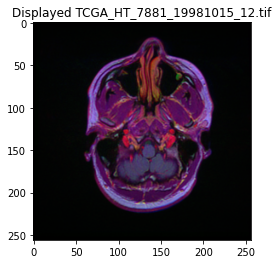

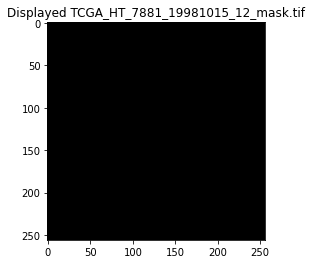

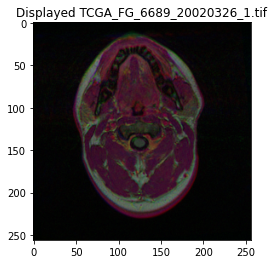

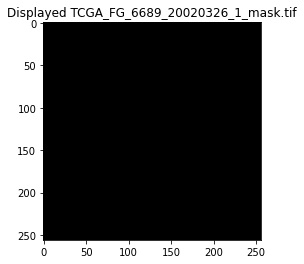

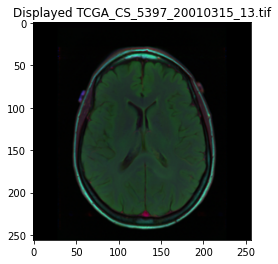

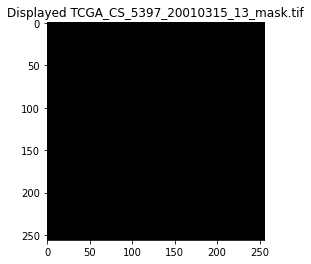

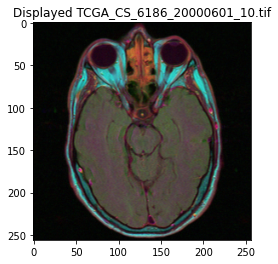

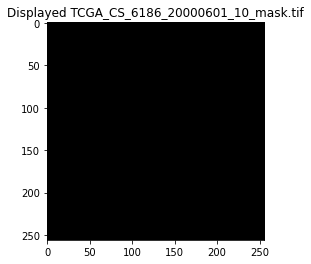

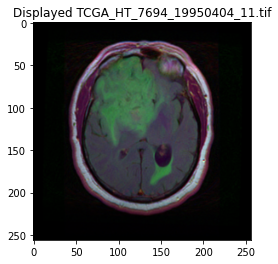

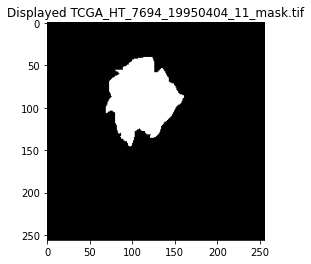

In [9]:
# displaying few samples
for _ in range(5):
  mask_file_name = random.choice(train_mask_file_path)
  file_name = mask_file_name.replace('_mask','')
  img =cv2.imread(file_name)
  img_mask = cv2.imread(mask_file_name)
  plt.imshow(img)
  plt.title("Displayed {}".format(file_name.split('/')[-1]))
  plt.show()
  plt.imshow(img_mask,cmap='gray')
  plt.title("Displayed {}".format(mask_file_name.split('/')[-1]))
  plt.show()

# Architecture of Unet

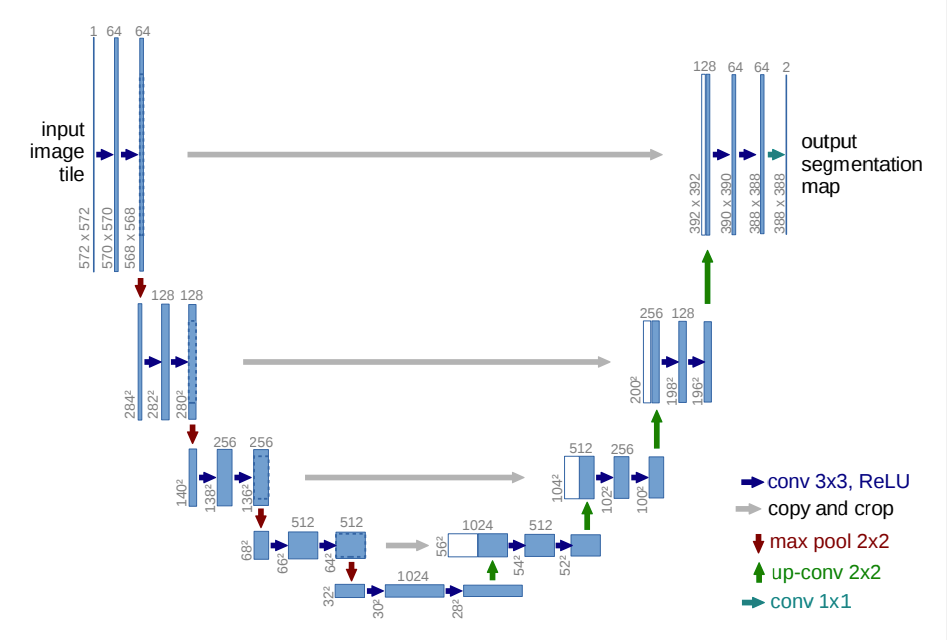

In [28]:
# terming series of 2 conv in the encoder layer i.e left part of U as conv_block and using it repeatedly
class UNET(nn.Module):
  def __init__(self, input_channels=3,output_channels=1,num_features=32):
    super().__init__()
    features = num_features
    #architecture of Unet3D deriving conv blocks
    # Stage 1
    self.encoder1 = UNET.conv_block(input_channels,features, name="conv_encoder1")
    self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
    # Stage 2 
    self.encoder2 = UNET.conv_block(features,features*2, name="conv_encoder2")
    self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
    # Stage 3
    self.encoder3 = UNET.conv_block(features*2,features*4, name="conv_encoder3")
    self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
    # Stage 4
    self.encoder4 = UNET.conv_block(features*4,features*8, name="conv_encoder4")
    self.pool4 = nn.MaxPool2d(kernel_size=2,stride=2)
    # Stage 5 - Bottom part of U, Bottleneck
    self.bottleneck_layer = UNET.conv_block(features*8,features*16, name="bottleneck_layer")
    # Stage 6 - Going up in the U in the decoder layer
    self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride =2)
    #followed by conv block
    self.decoder4 = UNET.conv_block(features*16, features*8, name='conv_decoder4')
    # Stage 7 - Going up in the U in the decoder layer
    self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride =2)
    #followed by conv block
    self.decoder3 = UNET.conv_block(features*8, features*4, name='conv_decoder3')
    # Stage 8 - Going up in the U in the decoder layer
    self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride =2)
    #followed by conv block
    self.decoder2 = UNET.conv_block(features*4, features*2, name='conv_decoder2')
    # Stage 8 - Going up in the U in the decoder layer
    self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride =2)
    #followed by conv block
    self.decoder1 = UNET.conv_block(features*2, features, name='conv_decoder1')
    #mask generation conv layer
    self.conv = nn.Conv2d(in_channels=features, out_channels=output_channels, kernel_size=1)


  #defining forward pass
  def forward(self,x):
    #encoder pass
    encoder_out1 = self.encoder1(x)
    encoder_out2 = self.encoder2(self.pool1(encoder_out1))
    encoder_out3 = self.encoder3(self.pool2(encoder_out2))
    encoder_out4 = self.encoder4(self.pool3(encoder_out3))

    bottleneck_out = self.bottleneck_layer(self.pool4(encoder_out4))
    #decoder pass
    decoder_out4 = self.upconv4(bottleneck_out)
    #concat
    decoder_out4 = torch.cat((decoder_out4,encoder_out4),dim=1)
    #upconv
    decoder_out4 = self.decoder4(decoder_out4)

    decoder_out3 = self.upconv3(decoder_out4)
    #concat
    decoder_out3 = torch.cat((decoder_out3,encoder_out3),dim=1)
    #upconv
    decoder_out3 = self.decoder3(decoder_out3)

    decoder_out2 = self.upconv2(decoder_out3)
    #concat
    decoder_out2 = torch.cat((decoder_out2,encoder_out2),dim=1)
    #upconv
    decoder_out2 = self.decoder2(decoder_out2)

    decoder_out1 = self.upconv1(decoder_out2)
    #concat
    decoder_out1 = torch.cat((decoder_out1,encoder_out1),dim=1)
    #upconv
    decoder_out1 = self.decoder1(decoder_out1)
    #passing through sigmoid layer to generate mask

    return torch.sigmoid(self.conv(decoder_out1))


  #defining the conv block layer method
  @staticmethod
  def conv_block(in_channels,num_features,name):
    return nn.Sequential(
        OrderedDict(
            [
                (
                  name+"conv_1",
                  nn.Conv2d(in_channels=in_channels,out_channels=num_features, kernel_size=3,padding=1,bias=False),#keep Bias equals false for batch normalisation
                ),
             (
                 name+"batch_norm_1", nn.BatchNorm2d(num_features=num_features)
             ),
             (
                 name+"relu_1", nn.ReLU(inplace=True)
             ),
             (
                 name+"conv_2",
              nn.Conv2d(in_channels=num_features, out_channels=num_features,kernel_size=3, padding=1,bias=False),
             ),
             (
                name+"batch_norm_2",nn.BatchNorm2d(num_features=num_features)
             ),
             (
                 name+"relu_2",nn.ReLU(inplace=True)
             )
            ]
        )
    )


In [29]:
model = UNET()

In [12]:
# preprocessing helper functions
# 1. cropping
def crop_sample(x):
  volume,mask = x
  volume[volume< np.max(volume)*0.1] =0
  #calculating z_proj
  z_proj = np.max(np.max(np.max(volume, axis=-1),axis=-1),axis=-1)
  z_nonzero = np.nonzero(z_proj)
  z_min = np.min(z_nonzero)
  z_max = np.max(z_nonzero)+1
  #calculating y_proj
  y_proj = np.max(np.max(np.max(volume, axis=0),axis=-1),axis=-1)
  y_nonzero = np.nonzero(y_proj)
  y_min = np.min(y_nonzero)
  y_max = np.max(y_nonzero)+1
  #calculating x_proj
  x_proj = np.max(np.max(np.max(volume, axis=0),axis=0),axis=-1)
  x_nonzero = np.nonzero(x_proj)
  x_min = np.min(x_nonzero)
  x_max = np.max(x_nonzero)+1
  volume_cropped = volume[z_min:z_max,y_min:y_max,x_min:x_max]
  mask_cropped = mask[z_min:z_max,y_min:y_max,x_min:x_max]

  return volume_cropped, mask_cropped

In [13]:
#2. padding
def pad_sample(x):
  volume, mask=x
  a = volume.shape[1]
  b= volume.shape[2]
  if a == b:
    return volume,mask
  diff = (max(a,b) - min(a,b))/2.0
  if a>b:
    padding =((0,0),(0,0),(int(np.floor(diff)),int(np.ceil(diff))))
  else:
    padding=((0,0),(int(np.floor(diff)),int(np.ceil(diff))),(0,0))
  mask = np.pad(mask,padding, mode='constant', constant_values=0)
  padding = padding+((0,0),)
  volume = np.pad(volume, padding,mode='constant', constant_values=0)

  return volume, mask

In [14]:
#3. Resizing
def resize_sample(x,size=256):
  volume,mask=x
  v_shape = volume.shape
  out_shape = (v_shape[0],size,size)
  mask = resize(
      mask, output_shape=out_shape,
      order=0,
      mode='constant',
      cval=0,
      anti_aliasing= False,
  )
  out_shape = out_shape + (v_shape[3],)
  volume = resize(
      volume,
      output_shape = out_shape,
      order=2,
      mode='constant',
      cval=0,
      anti_aliasing = False,
  )
  return volume, mask


In [15]:
# 4. Normalizing
def normalize_volume(volume):
  p10 = np.percentile(volume,10)
  p99 = np.percentile(volume,99)
  volume = rescale_intensity(volume, in_range=(p10,p99))
  mean = np.mean(volume, axis=(0,1,2))
  standard_dev = np.std(volume, axis=(0,1,2))
  volume = (volume - mean)/standard_dev
  return volume

In [16]:
#5. Logging
def gray2rgb(image):
  w,h = image.shape
  image+=np.abs(np.min(image))
  image_max = np.abs(np.max(image))
  if image_max>0:
    image/=image_max
  ret = np.empty((w,h,3), dtype=np.uint8)
  ret[:,:,2] = ret[:,:,1]= ret[:,:,0] = image*255
  return ret

def outline(image,mask,color):
  mask= np.round(mask)
  yy,xx = np.nonzero(mask)
  for y,x in zip(yy,xx):
    if 0.0 <np.mean(mask[max(0,y-1):y+2,max(0,x-1):x+2])<1.0:
      image[max(0,y):y+1, max(0,x):x+1]=color
  return image


def log_images(x,y_true,y_pred,channel=1):
  images=[]
  x_np = x[:,channel].cpu().numpy()
  y_true_np= y_true[:,channel].cpu().numpy()
  y_pred_np =y_pred[:,channel].cpu().numpy()
  for i in range(x_np.shape[0]):
    image = gray2rgb(np.squeeze(x_np[i]))
    image= outline(image,y_pred_np[i],colors=[255,0,0])
    image = outline(image,y_true_np[i],colors=[0,255,0])
    images.append(image)
  return images



In [17]:
# defining helper function for transforms to be used in Data Loader

#1 . Scaling class
class Scale(object):#inheriting python object
  def __init__(self,scale):
    self.scale = scale
  
  def __call__(self,sample):
    image,mask = sample
    img_size= image.shape[0]
    scale = np.random.uniform(low=1.0-self.scale, high=1.0+self.scale)

    #rescaling image
    image = rescale(
        image,
        (scale,scale),multichannel=True,preserve_range=True,
        mode="constant", anti_aliasing = False,
    )
    mask = rescale(
        mask,(scale,scale), order=0,
        multichannel=True, preserve_range=True,
        mode = "constant", anti_aliasing=False,
    )
    if scale<1.0:
      diff = (img_size-image.shape[0])/2.0
      padding = ((int(np.floor(diff)), int(np.ceil(diff))),)*2 +((0,0),)
      image = np.pad(image, padding,mode="constant",constant_values=0)
      mask = np.pad(mask,padding,mode="constant", constant_values=0)

    else:
      x_min = (image.shape[0]- img_size)//2
      x_max = x_min+img_size
      image = image[x_min:x_max, x_min:x_max, ...]
      mask = mask[x_min:x_max,x_min:x_max,...]
    
    return image, mask

In [18]:
#2. Rotation class
class Rotate(object):
  def __init__(self,angle):
    self.angle = angle

  def __call__(self,sample):
    image,mask = sample
    angle = np.random.uniform(low=-self.angle, high= self.angle)
    image = rotate(image, angle,resize=False, preserve_range=True, mode="constant")
    mask= rotate(mask,angle,resize=False,order=0, preserve_range=True, mode="constant")
    return image, mask
    


In [19]:
#3. Horizontal flip class
class HorizontalFlip(object):
  def __init__(self,flip_prob):
    self.flip_prob = flip_prob
  
  def __call__(self,sample):
    image,mask = sample

    if np.random.rand()>self.flip_prob:
      return image,mask
    
    image = np.fliplr(image).copy()
    mask = np.fliplr(mask).copy()

    return image,mask

In [20]:
#applying transform using all the helper function
def transforms(scale=None, angle=None, flip_prob=None):
  transforms_list = []
  if scale is not None:
    transforms_list.append(Scale(scale))
  if angle is not None:
    transforms_list.append(Rotate(angle))
  if flip_prob is not None:
    transforms_list.append(HorizontalFlip(flip_prob))
  
  return Compose(transforms_list)

In [21]:
#creating Dataset class
class BrainMRIDataset(torch.utils.data.Dataset):
  in_channels = 3
  out_channels = 1

  def __init__(self,images_dir, transform=None, image_size=256, subset="train",random_sampling=True, validation_cases=10,seed=42):
    assert subset in ["all","train","val"]
    #reading images
    image_volumes = {}
    masks = {}
    print("reading {} images and masks".format(subset))
    for (dir_path,dirnames,filenames) in os.walk(images_dir):
      image_slices = []
      mask_slices = []
      for filename in sorted(
          filter(lambda f: ".tif" in f,filenames),
          key=lambda x: int(x.split(".")[-2].split("_")[4])
      ):
        file_path = os.path.join(dir_path,filename)
        if "mask" in filename:
          mask_slices.append(imread(file_path,as_gray=True))
        else:
          image_slices.append(imread(file_path))
      if len(image_slices)>0:
        patient_id = dir_path.split("/")[-1]
        image_volumes[patient_id] = np.array(image_slices[1:-1])
        masks[patient_id] = np.array(mask_slices[1:-1])
        print("{} images read".format(len(image_slices)))

        
    self.patients = sorted(image_volumes)

    if not subset=="all":
      random.seed(seed)
      validation_patients = random.sample(self.patients,k=validation_cases)
      if subset =="val":
        self.patients = validation_patients
      else:
        self.patients = sorted(list(set(self.patients).difference(validation_patients)))
    
    print("preprocessing {} volumes..".format(subset))

    self.image_volumes = [(image_volumes[k], masks[k]) for k in self.patients]

    #cropping
    print("cropping {} volumes".format(subset))
    self.image_volumes = [crop_sample(v) for v in self.image_volumes]

    #padding
    print("padding {} volumes".format(subset))
    self.image_volumes = [pad_sample(v) for v in self.image_volumes]

    #resizing
    print("Resizing {} volumes".format(subset))
    self.image_volumes = [resize_sample(v,size=image_size) for v in self.image_volumes]

    #normalising
    print("Normalising {} volumes".format(subset))
    self.image_volumes = [(normalize_volume(v),m) for v,m in self.image_volumes]

    # probab for sampling slices based on masks
    self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v,m in self.image_volumes]

    self.slice_weights =[
        (s +(s.sum()*0.1/len(s)))/(s.sum()*1.1) for s in self.slice_weights
    ]
    #adding channel dimension to mask

    self.image_volumes = [(v,m[...,np.newaxis]) for (v,m) in self.image_volumes]

    print("Dataset creation done for {}".format(subset))

    #create global index for patient and slice

    num_slices = [v.shape[0] for v,m in self.image_volumes]
    self.patient_slice_index = list(
        zip(
            sum([[i]* num_slices[i] for i in range(len(num_slices))],[]),
            sum([list(range(x)) for x in num_slices],[])
        )
    )
    self.random_sampling = random_sampling
    self.transform = transform


  def __len__(self):
    return len(self.patient_slice_index)

  def __getitem__(self,idx):
    patient = self.patient_slice_index[idx][0]
    slice_n = self.patient_slice_index[idx][1]

    if self.random_sampling:
      patient = np.random.randint(len(self.image_volumes))
      slice_n = np.random.choice(
          range(self.image_volumes[patient][0].shape[0]), p = self.slice_weights[patient])
    
    v,m = self.image_volumes[patient]
    image = v[slice_n]
    mask = m[slice_n]

    if self.transform is not None:
      image,mask = self.transform((image,mask))

    #fixing dimensions to match pytorch since transform is done via CV,
    image = image.transpose(2,0,1)
    mask = mask.transpose(2,0,1)

    image_tensor = torch.from_numpy(image.astype(np.float32))
    mask_tensor = torch.from_numpy(mask.astype(np.float32))

    return image_tensor,mask_tensor

In [22]:
#creating data loader

batch_size=2
def datasets():
  scale=0.02
  angle=10
  image_size=128
  images= "/content/drive/MyDrive/dataset/kaggle_3m"
  train_dataset = BrainMRIDataset(
      images_dir= images,
      subset="train",
      image_size=image_size,
      transform = transforms(scale=scale,angle=angle,flip_prob=0.5)
  )
  val_dataset = BrainMRIDataset(
      images_dir= images,
      subset="val",
      image_size=image_size,
      random_sampling = False
  )
  return train_dataset,val_dataset

In [23]:
def data_loaders():
  train_data, val_data = datasets()

  train_loader = DataLoader(
      train_data,batch_size=batch_size,shuffle=True,
      drop_last = True, num_workers=4
  )

  val_loader = DataLoader(
      val_data, batch_size=batch_size,shuffle = True,
      drop_last=True, num_workers =4
  )

  return train_loader,val_loader


In [52]:
#helper functions
# IOU = Dice loss/2-Dice Loss
# Dice loss = 2 * interesection/total
class DiceLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.smooth = 1.0

  def forward(self,y_pred,y_true):
    assert y_pred.size() == y_true.size() 
    y_pred = y_pred[:,0].contiguous().view(-1)
    y_true = y_true[:,0].contiguous().view(-1)
    intersection = (y_pred*y_true).sum()
    dice_score = (2.0* intersection*self.smooth)/(y_pred.sum()+y_true.sum()+self.smooth)

    return 1.0 -dice_score



In [53]:
#general helper function
def dice_score(y_pred,y_true):
  if np.any(y_pred):
    y_pred = np.round(y_pred).astype(int)
    y_true = np.round(y_true).astype(int)
    y_pred = largest_connected_component(y_pred)
    dice_loss = np.sum(y_pred[y_true==1])*2.0/(np.sum(y_pred)+np.sum(y_true))
  return dice_loss

def dice_score_per_vol(val_pred,val_true, patient_slice_index):
  print(np.shape(val_pred),np.shape(val_true))
  dsc_list = []
  num_slices = np.bincount([p[0] for p in patient_slice_index])
  index=0
  for p in range(len(num_slices)):
    y_pred = np.array(val_pred[index:index+num_slices[p]])
    y_true = np.array(val_true[index:index+num_slices[p]])
    dsc_list.append(dice_score(y_pred,y_true))
    index += num_slices[p]
  
  return dsc_list

In [ ]:
# initialising the data loaders
num_epochs=100
device = torch.device("cuda")
torch.cuda.is_available()

train_loader , val_loader = data_loaders()
loaders = {'train':train_loader,'val':val_loader}

In [54]:
UNet = UNET()
UNet.to(device)
visualize_images = 2
dice_loss = DiceLoss()
best_val_dice_score=0.0

optimizer = optim.Adam(UNet.parameters(), lr=0.001)
train_loss = []
val_loss = []
step = 0

for epoch in tqdm(range(num_epochs),total=num_epochs):
  for phase in ["train","val"]:
    if phase == "train":
      UNet.train()
    else:
      UNet.eval()

    val_pred = []
    val_true = []

    for i, data in enumerate(loaders[phase]):
      if phase =="train":
        step+=1
      
      x,y_true = data
      #x= x.transpose(2,0,1)
      #y_true=y_true.transpose(2,0,1)
      x,y_true = x.to(device), y_true.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase=="train"):
        #print(x.shape,y_true.shape)
        y_pred = UNet(x)
        
        loss = dice_loss(y_pred,y_true)

        if phase == "val":
          val_loss.append(loss.item())
          y_pred_np = y_pred.detach().cpu().numpy()
          #y_pred_np=[t.detach().cpu().numpy().item() for t in y_pred]
          val_pred.extend(
              [y_pred_np[s] for s in range(y_pred_np.shape[0])]
          )

          y_true_np= y_true.detach().cpu().numpy()
          val_true.extend(
              [y_true_np[s] for s in range(y_true_np.shape[0])]
          )
          #10 == visualization frequency
          if (epoch%10==0) or (epoch == num_epochs-1):
            if i* batch_size < visualize_images:
              tag = "image/{}".format(i)
              num_images = visualize_images -i * batch_size

        
        if phase == "train":
          train_loss.append(loss.item())
          loss.backward()
          optimizer.step()

      if phase =="train" and (step+1)%1500 ==0:
        print("step- {}, train_loss-{}".format(step,sum(train_loss)/len(train_loss)))
        train_loss = []
    
  if phase =="val":
    print("step - {}, val_loss-{}".format(step,sum(val_loss)/len(val_loss)))
    mean_dice_score = np.mean(
        dice_score_per_vol(val_pred,val_true,
                           val_loader.dataset.patient_slice_index)
        
    )
    print("step- {}, mean dice score- {}".format(step,mean_dice_score))

    if mean_dice_score > best_val_dice_score:
        best_val_dice_score = mean_dice_score
        torch.save(UNet.state_dict(),"unet_brain_mri.pt")
    val_loss = []

print("Best val mean dice score -{}".format(best_val_dice_score))



  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


step- 1499, train_loss-0.3647803132576971
step - 1668, val_loss-0.5524305252425642
(332, 1, 128, 128) (332, 1, 128, 128)
step- 1668, mean dice score- 0.30259183812109786


  1%|          | 1/100 [01:22<2:15:21, 82.04s/it]

step- 2999, train_loss-0.2631165518363317
step - 3336, val_loss-0.5251604997249971
(332, 1, 128, 128) (332, 1, 128, 128)
step- 3336, mean dice score- 0.3227672420780474


  2%|▏         | 2/100 [02:46<2:16:01, 83.28s/it]

step- 4499, train_loss-0.2374898314078649
step - 5004, val_loss-0.4804789355720382
(332, 1, 128, 128) (332, 1, 128, 128)


  3%|▎         | 3/100 [04:09<2:14:50, 83.41s/it]

step- 5004, mean dice score- 0.3504527806025411
step- 5999, train_loss-0.20880116033554078
step - 6672, val_loss-0.47963849643626844
(332, 1, 128, 128) (332, 1, 128, 128)
step- 6672, mean dice score- 0.3631158533965747


  4%|▍         | 4/100 [05:32<2:12:57, 83.10s/it]

step- 7499, train_loss-0.19530634248256684
step - 8340, val_loss-0.4772650226052985
(332, 1, 128, 128) (332, 1, 128, 128)


  5%|▌         | 5/100 [06:56<2:12:10, 83.48s/it]

step- 8340, mean dice score- 0.38524530282271247
step- 8999, train_loss-0.18723847981293995


  6%|▌         | 6/100 [08:20<2:10:53, 83.55s/it]

step - 10008, val_loss-0.4921101845172514
(332, 1, 128, 128) (332, 1, 128, 128)
step- 10008, mean dice score- 0.37678249832017735
step- 10499, train_loss-0.17280081379413606
step - 11676, val_loss-0.49490646138248673
(332, 1, 128, 128) (332, 1, 128, 128)


  7%|▋         | 7/100 [09:44<2:10:01, 83.89s/it]

step- 11676, mean dice score- 0.43689735466606283
step- 11999, train_loss-0.1673661121527354


  8%|▊         | 8/100 [11:10<2:09:16, 84.31s/it]

step - 13344, val_loss-0.4482815797070423
(332, 1, 128, 128) (332, 1, 128, 128)
step- 13344, mean dice score- 0.4038844657519188
step- 13499, train_loss-0.15770151495933532
step- 14999, train_loss-0.1523557919661204


  9%|▉         | 9/100 [12:34<2:08:06, 84.46s/it]

step - 15012, val_loss-0.4337278715817325
(332, 1, 128, 128) (332, 1, 128, 128)
step- 15012, mean dice score- 0.41050709607005065
step- 16499, train_loss-0.15069678548971813
step - 16680, val_loss-0.48206356455044574
(332, 1, 128, 128) (332, 1, 128, 128)
step- 16680, mean dice score- 0.4587814908488184


 10%|█         | 10/100 [13:58<2:06:06, 84.07s/it]

step- 17999, train_loss-0.14241240445772807
step - 18348, val_loss-0.44635300894817675
(332, 1, 128, 128) (332, 1, 128, 128)


 11%|█         | 11/100 [15:36<2:11:14, 88.47s/it]

step- 18348, mean dice score- 0.34588001175236543
step- 19499, train_loss-0.1447453886270523


 12%|█▏        | 12/100 [17:05<2:09:58, 88.62s/it]

step - 20016, val_loss-0.4463560042611088
(332, 1, 128, 128) (332, 1, 128, 128)
step- 20016, mean dice score- 0.42638221349448246
step- 20999, train_loss-0.1431758872270584
step - 21684, val_loss-0.46283538908843536
(332, 1, 128, 128) (332, 1, 128, 128)
step- 21684, mean dice score- 0.45946176059666577


 13%|█▎        | 13/100 [18:32<2:07:40, 88.05s/it]

step- 22499, train_loss-0.1374620350599289


 14%|█▍        | 14/100 [19:55<2:04:20, 86.75s/it]

step - 23352, val_loss-0.4609088836664177
(332, 1, 128, 128) (332, 1, 128, 128)
step- 23352, mean dice score- 0.4459908564334326
step- 23999, train_loss-0.14209961438179017


 15%|█▌        | 15/100 [21:20<2:01:45, 85.95s/it]

step - 25020, val_loss-0.46702753456242113
(332, 1, 128, 128) (332, 1, 128, 128)
step- 25020, mean dice score- 0.3388691358600754
step- 25499, train_loss-0.1426265781323115


 16%|█▌        | 16/100 [22:42<1:58:47, 84.85s/it]

step - 26688, val_loss-0.42455416917800903
(332, 1, 128, 128) (332, 1, 128, 128)
step- 26688, mean dice score- 0.4153511505555822
step- 26999, train_loss-0.13326128764947257


 17%|█▋        | 17/100 [24:17<2:01:35, 87.89s/it]

step - 28356, val_loss-0.4064413976956563
(332, 1, 128, 128) (332, 1, 128, 128)
step- 28356, mean dice score- 0.3912651501935927
step- 28499, train_loss-0.1330806748867035


 17%|█▋        | 17/100 [25:22<2:03:53, 89.56s/it]


KeyboardInterrupt: ignored

# Inference

In [58]:
phase = "val"
with torch.set_grad_enabled(False):
  unet = UNET()
  #loading the dataset
  state_dict = torch.load("unet_brain_mri.pt", map_location=device)
  unet.load_state_dict(state_dict)
  unet.eval()
  unet.to(device)

  input_list=[]
  pred_list = []
  true_list = []

  for i, date in tqdm(enumerate(loaders[phase])):
    x,y_true = data
    x,y_true = x.to(device),y_true.to(device)
    y_pred = unet(x)

    y_pred_np = y_pred.detach().cpu().numpy()
    pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

    y_true_np = y_true.detach().cpu().numpy()
    true_list.extend(
              [y_true_np[s] for s in range(y_true_np.shape[0])]
          )
    
    x_np = x.detach().cpu().numpy()
    input_list.extend(
              [x_np[s] for s in range(x_np.shape[0])]
          )


def postprocess_per_volume(input_list, pred_list,true_list,patient_slice_index,patients):
  volumes={}
  num_slices = np.bincount([p[0] for p in patient_slice_index])
  index = 0
  for p in range(len(num_slices)):
    volume_in = np.array(input_list[index:index+num_slices[p]])
    volume_pred = np.round(
        np.array(pred_list[index:index+num_slices[p]])
    ).astype(int)
    volume_pred = largest_connected_component(volume_pred)
    volume_true = np.array(true_list[index:index+num_slices[p]])

    volumes[patients[p]] = (volume_in, volume_pred, volume_true)
    index+= num_slices[p]
  
  return volumes

166it [00:01, 103.89it/s]


In [59]:
volumes = postprocess_per_volume(
    input_list,pred_list,true_list, loaders[phase].dataset.patient_slice_index,
    loaders[phase].dataset.patients,
)



In [66]:
#saving predictions
for p in volumes:
  x = volumes[p][0]
  y_pred = volumes[p][1]
  y_true = volumes[p][2]
  for s in range(x.shape[0]):
    image = gray2rgb(x[s,1])
    image = outline(image,y_pred[s,0], color=[255,0,0])
    image = outline(image,y_true[s,0], color=[0,255,0])
    file_name = "{}-{}.png".format(p,str(s).zfill(2))
    filepath = os.path.join("/content/drive/MyDrive/dataset/preds",file_name)
    imsave(filepath,image)
  


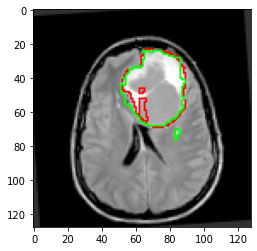

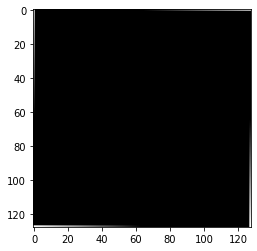

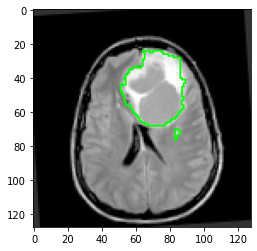

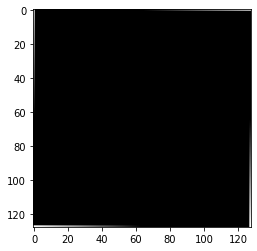

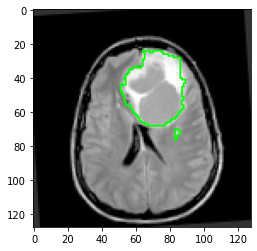

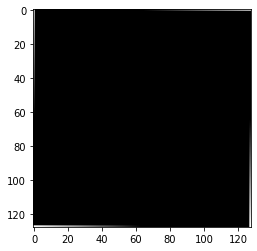

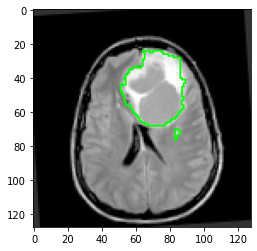

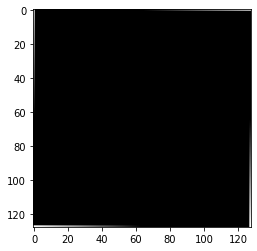

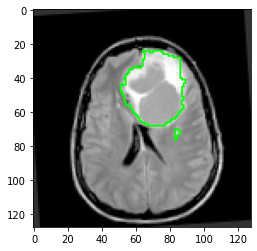

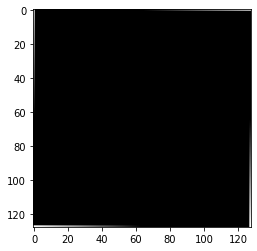

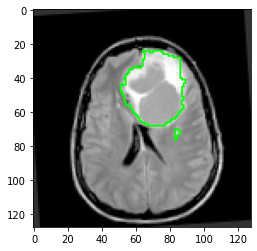

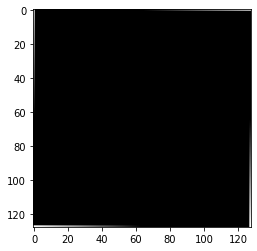

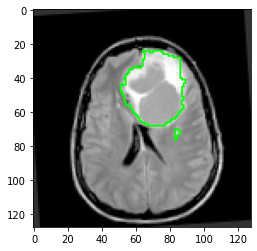

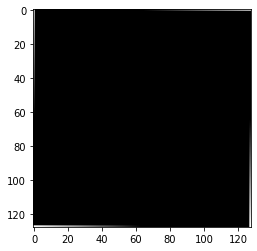

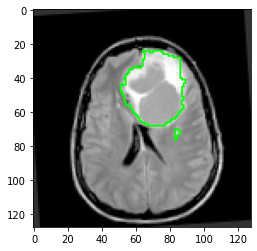

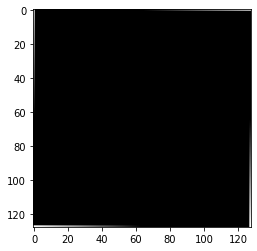

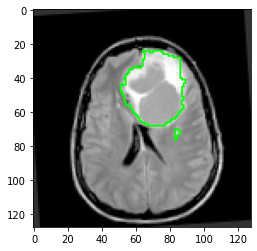

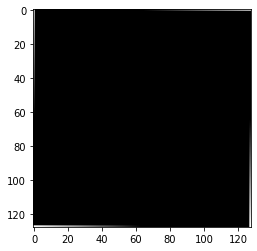

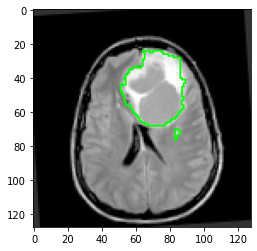

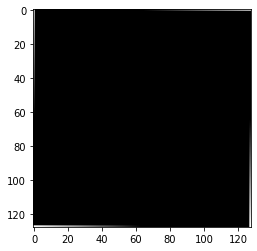

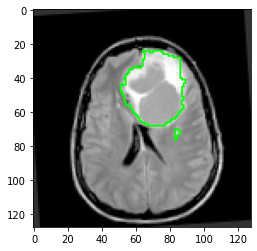

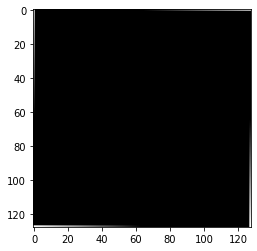

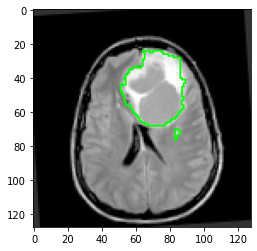

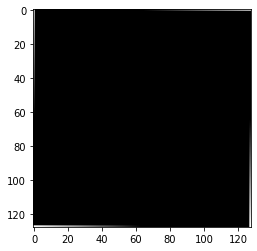

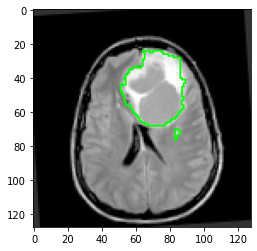

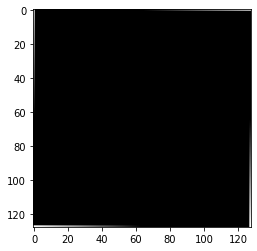

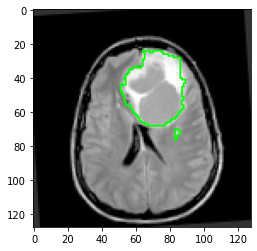

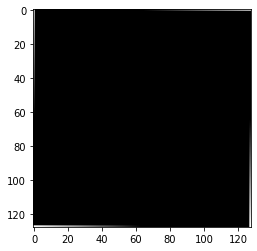

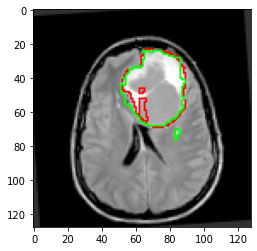

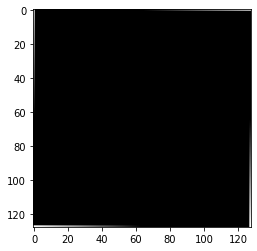

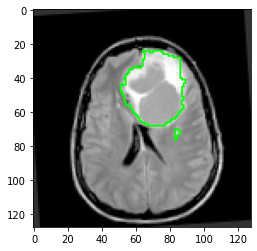

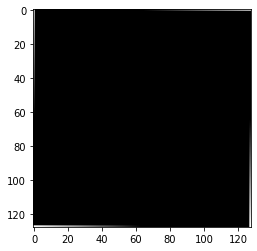

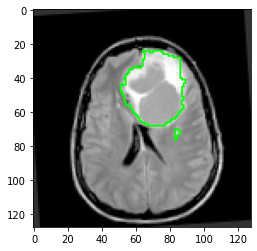

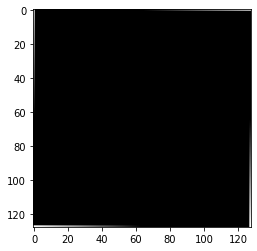

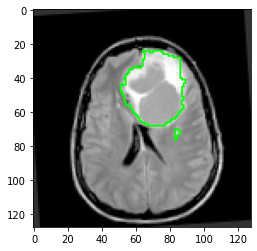

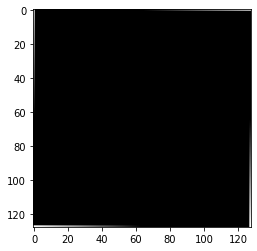

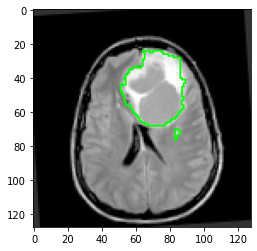

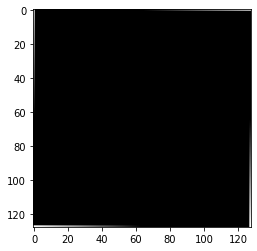

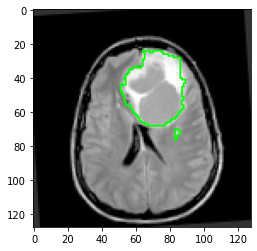

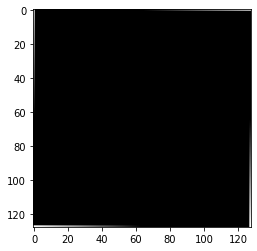

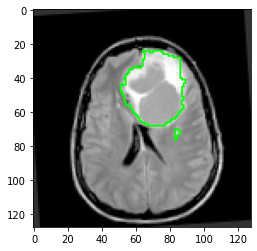

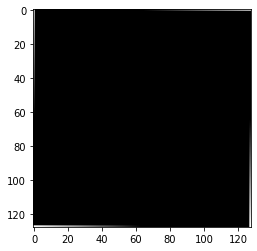

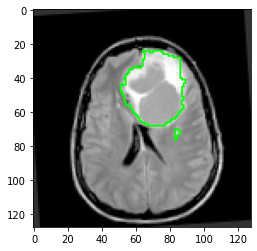

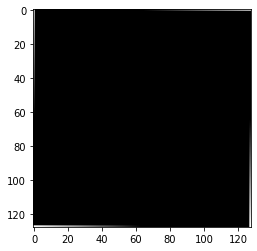

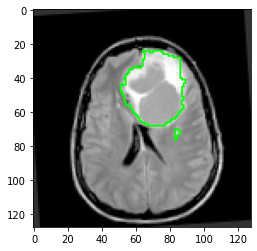

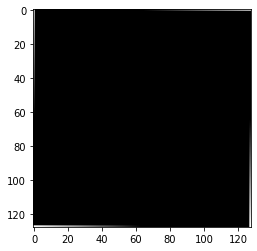

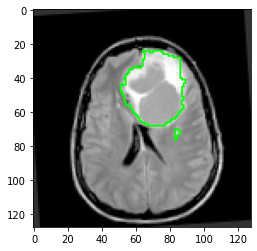

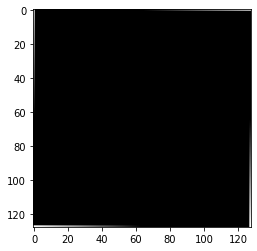

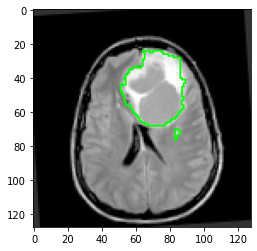

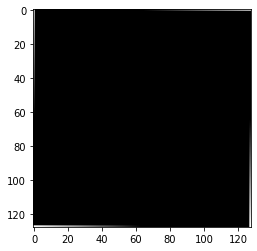

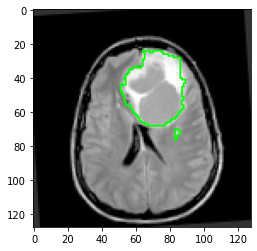

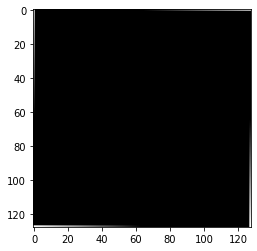

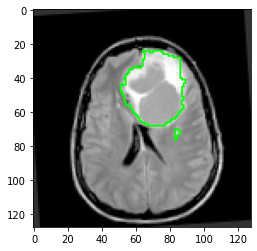

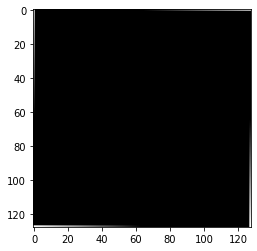

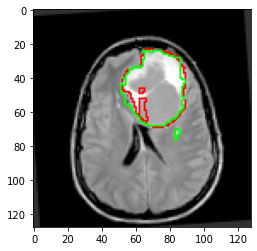

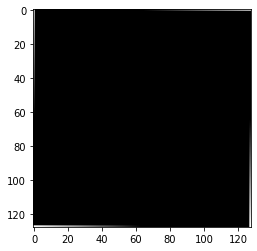

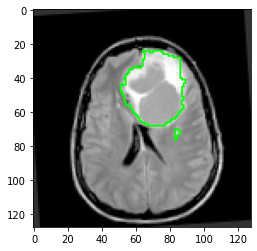

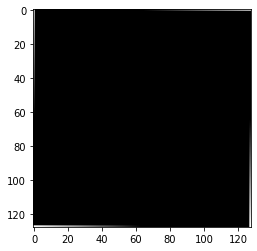

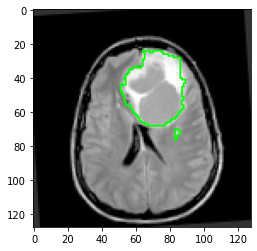

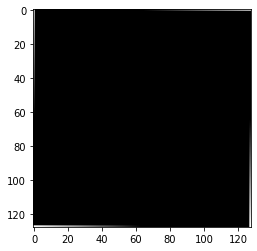

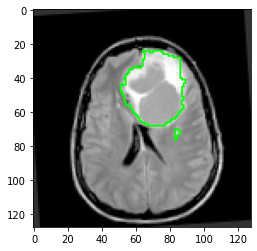

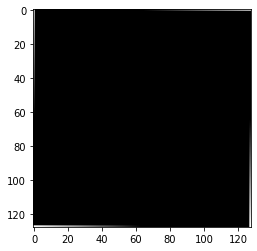

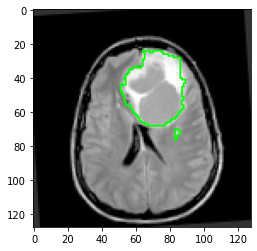

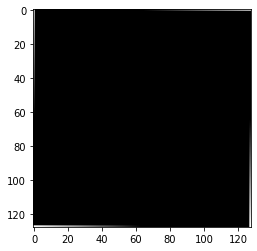

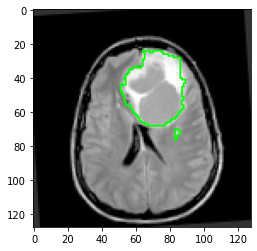

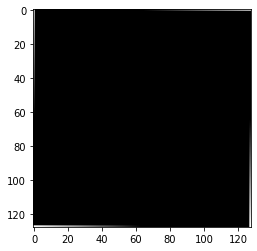

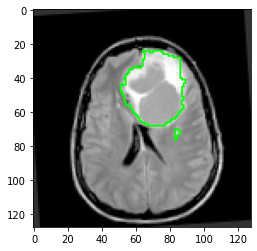

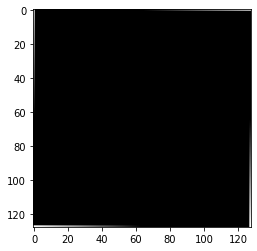

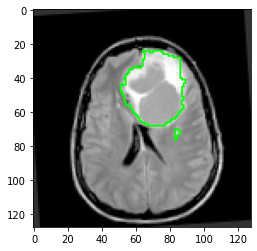

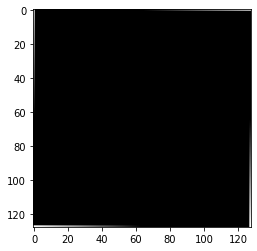

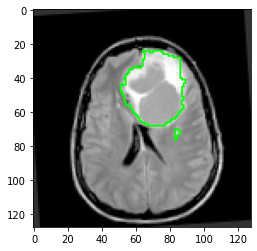

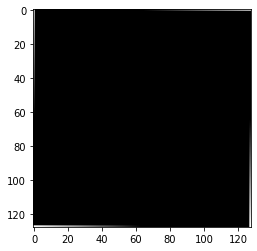

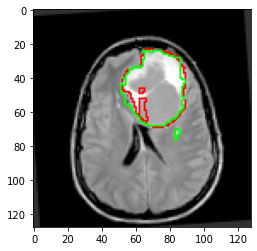

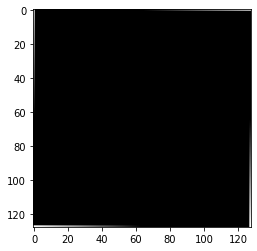

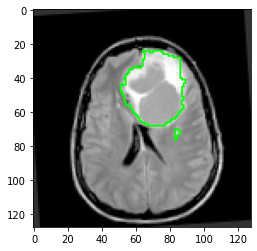

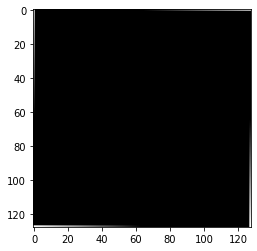

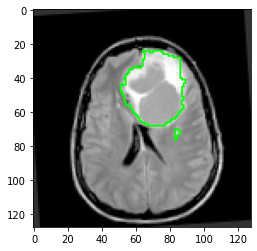

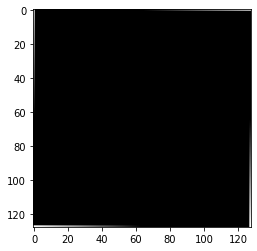

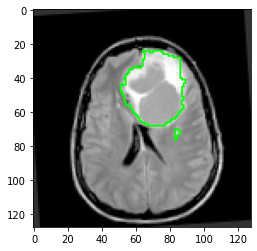

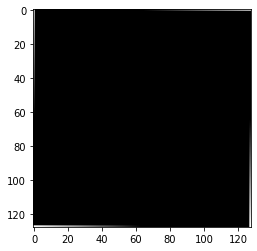

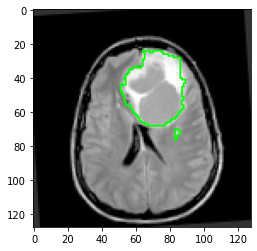

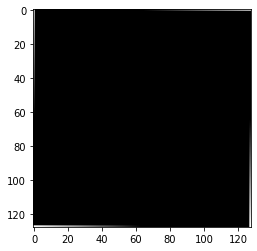

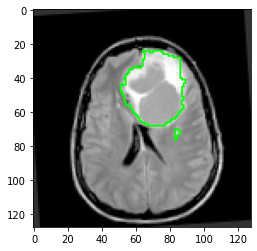

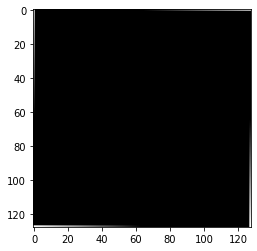

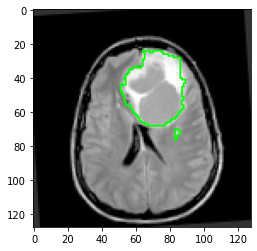

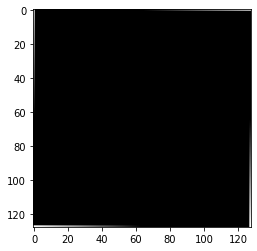

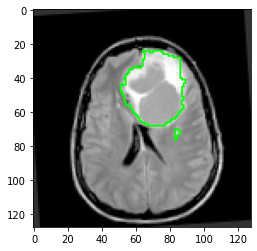

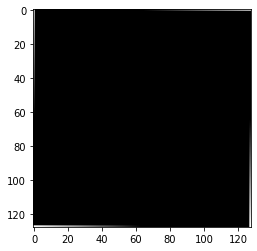

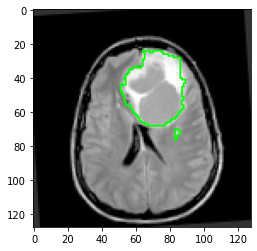

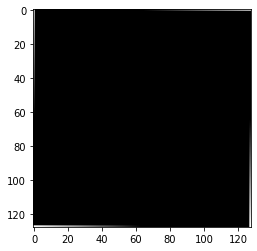

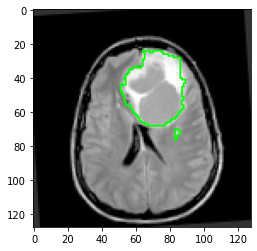

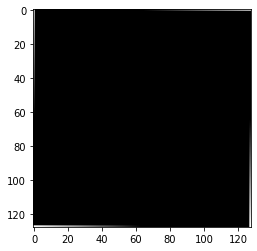

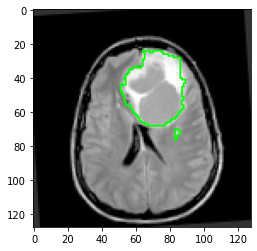

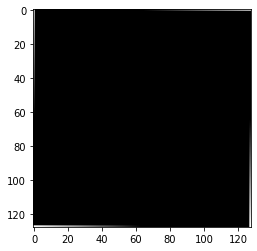

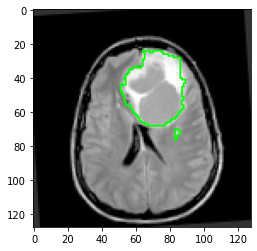

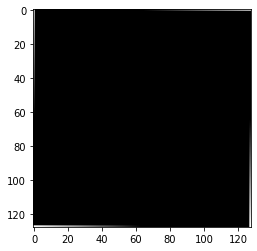

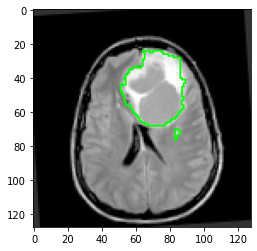

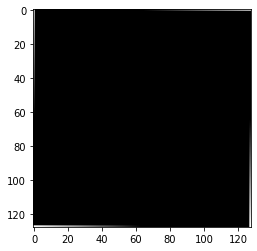

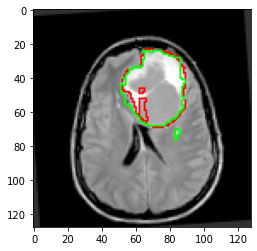

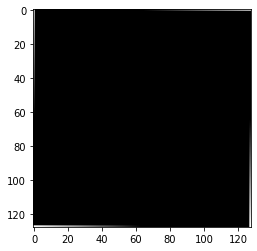

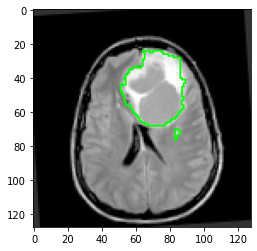

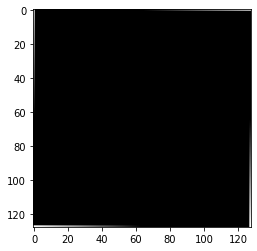

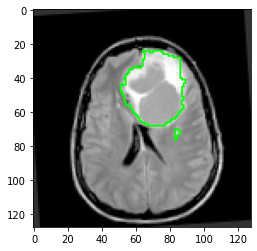

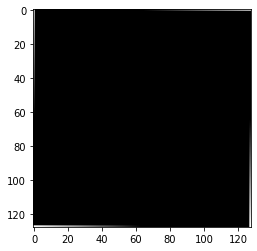

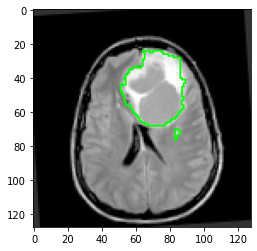

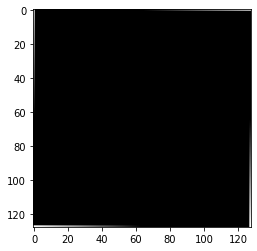

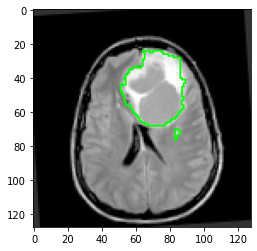

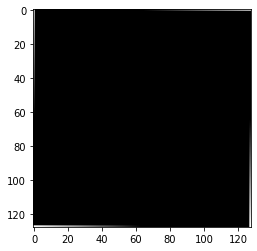

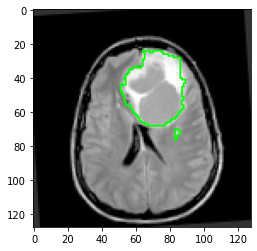

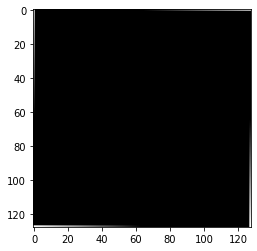

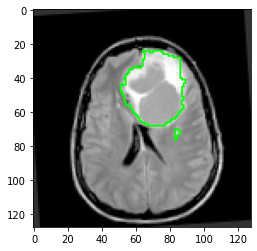

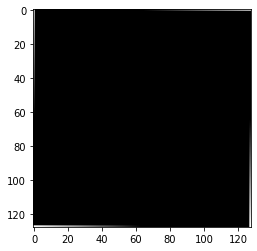

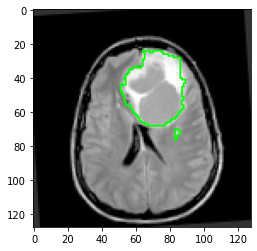

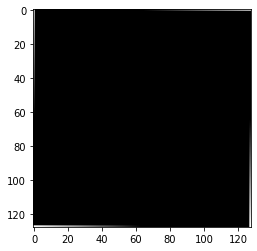

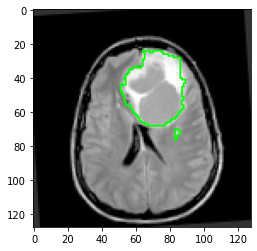

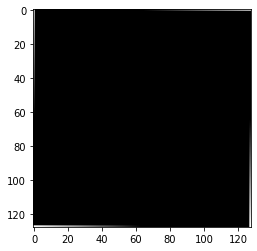

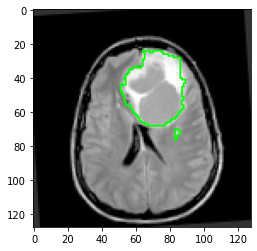

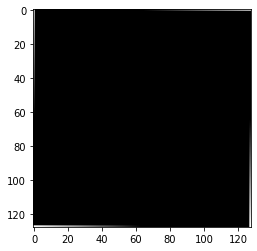

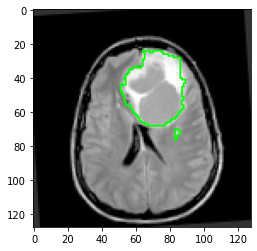

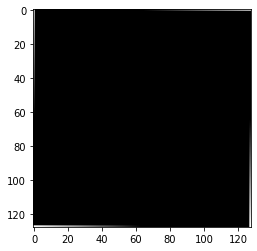

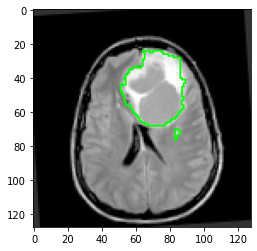

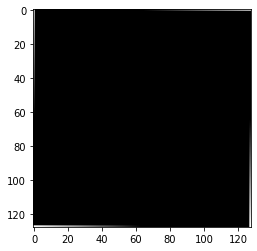

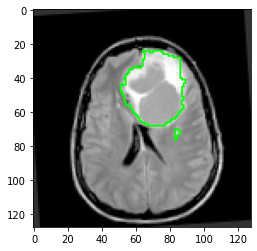

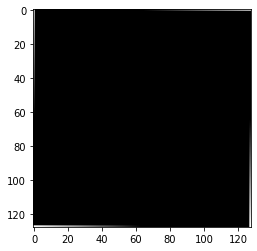

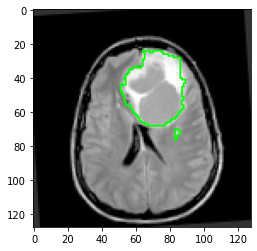

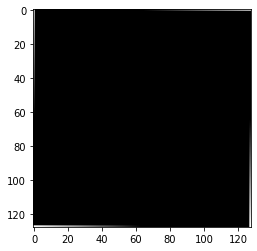

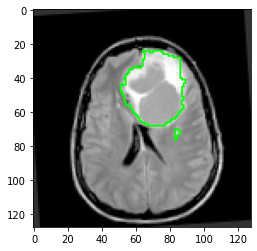

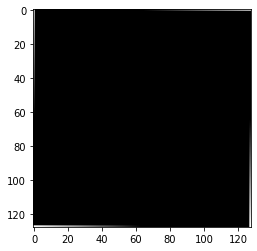

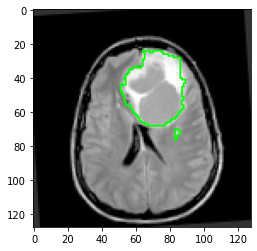

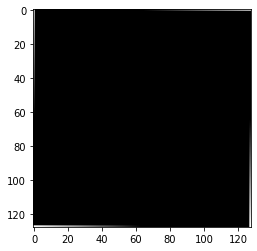

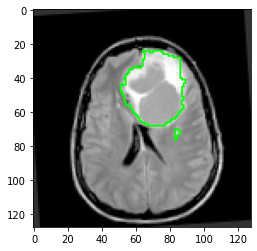

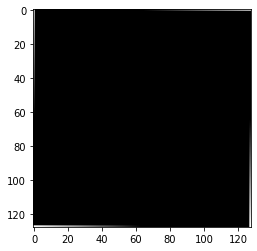

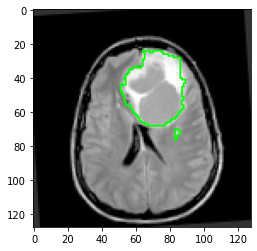

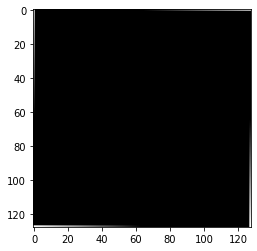

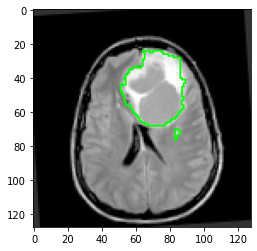

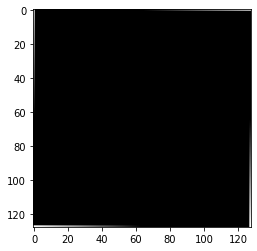

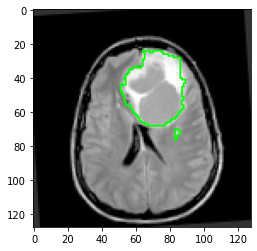

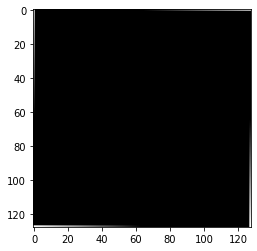

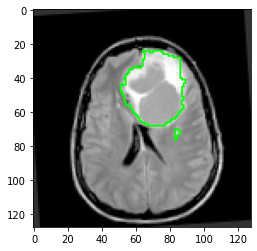

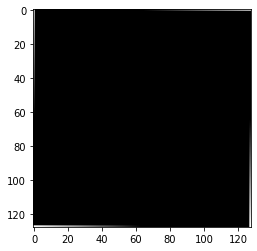

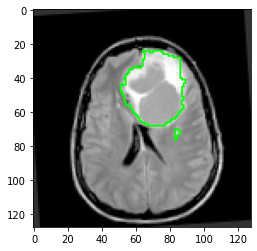

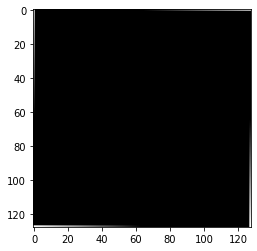

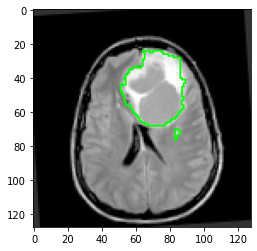

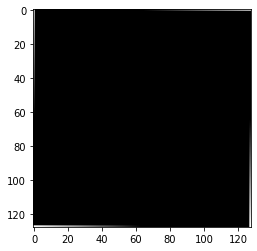

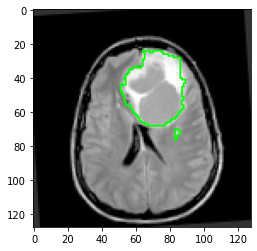

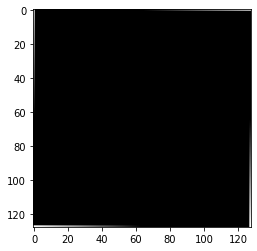

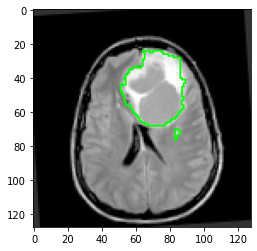

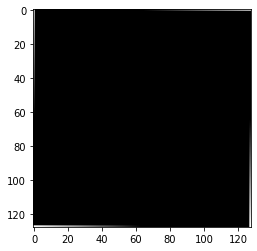

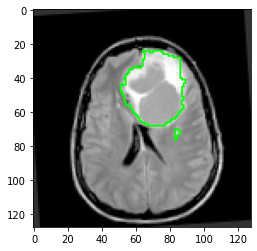

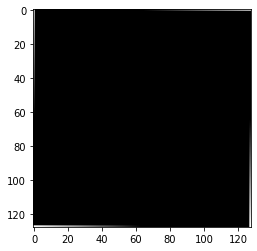

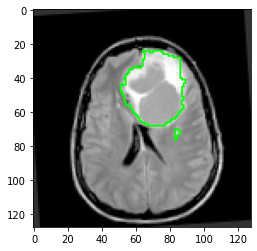

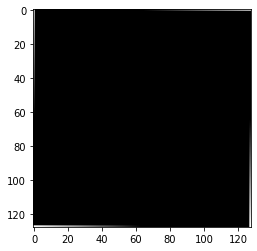

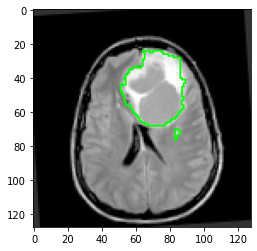

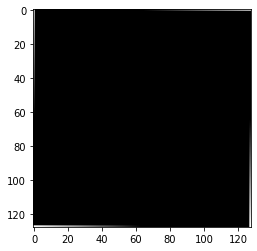

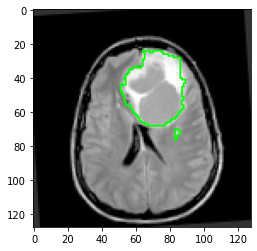

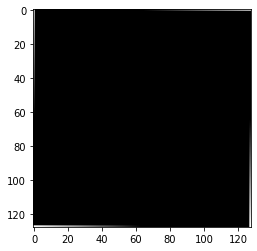

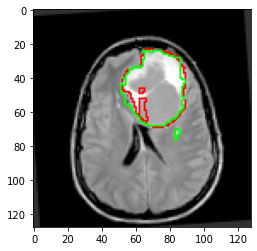

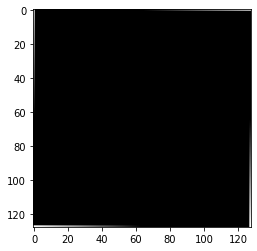

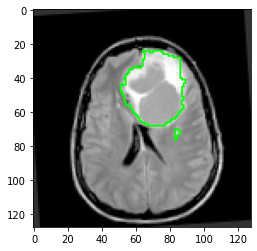

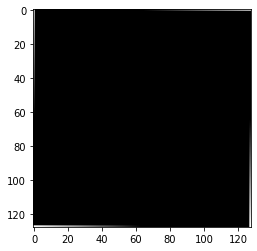

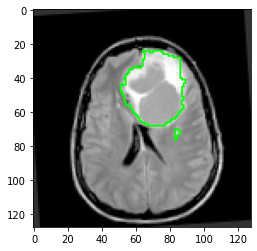

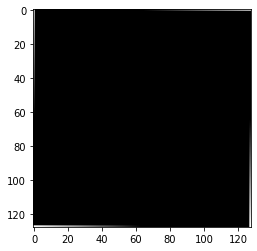

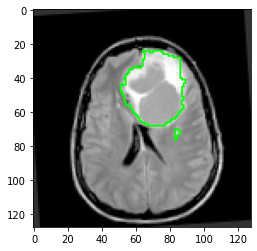

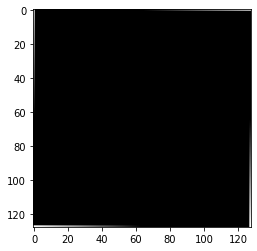

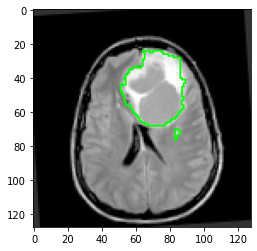

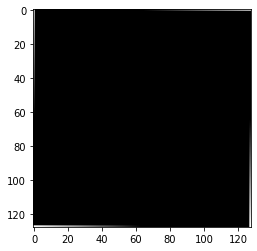

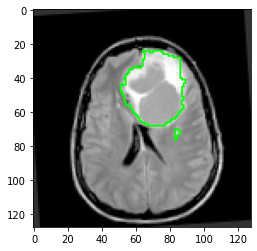

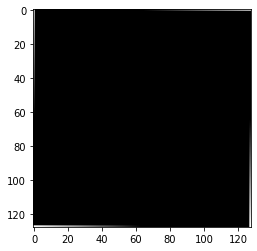

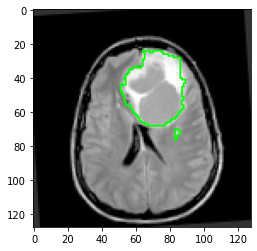

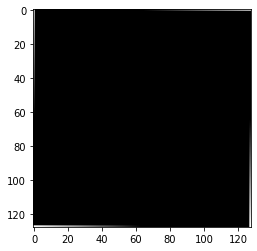

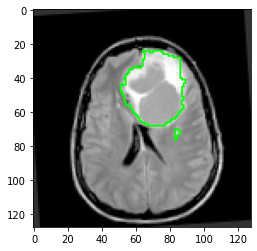

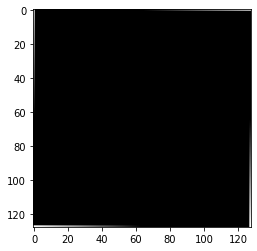

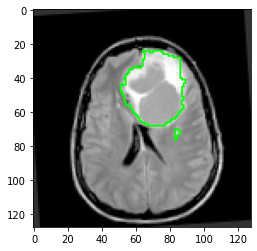

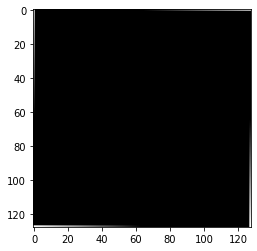

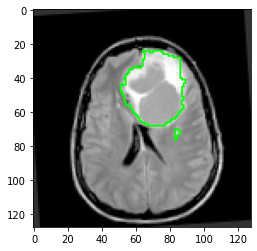

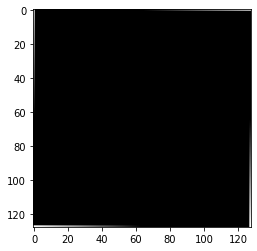

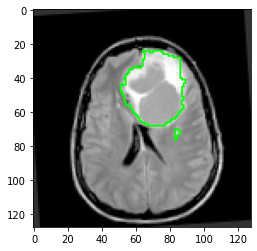

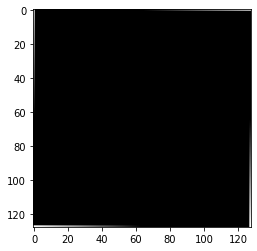

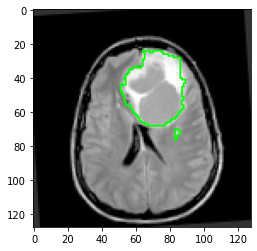

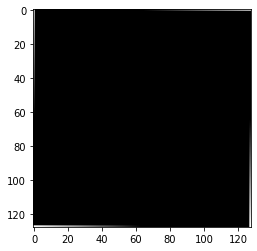

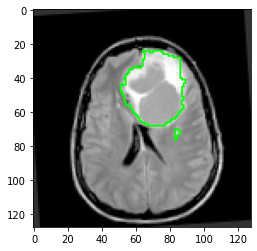

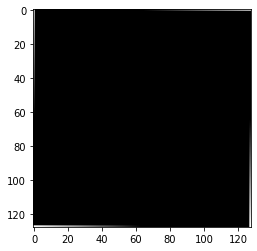

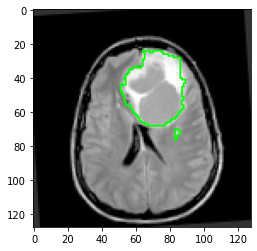

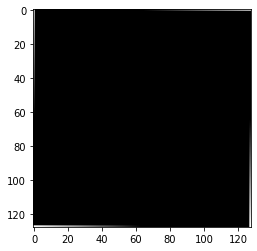

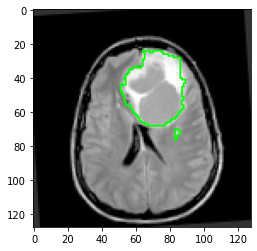

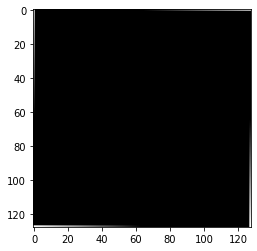

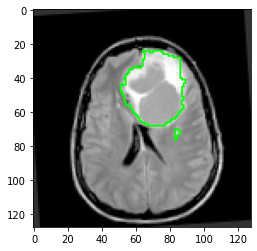

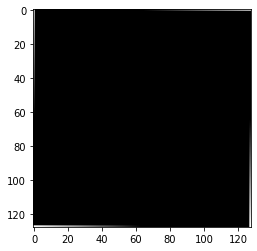

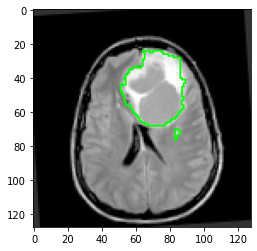

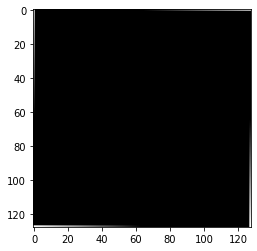

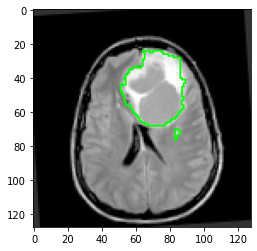

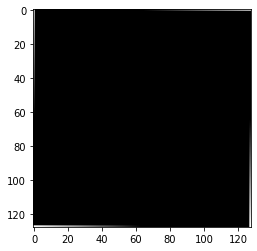

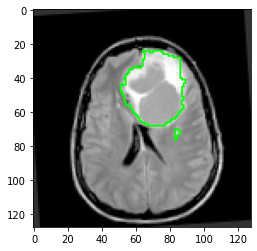

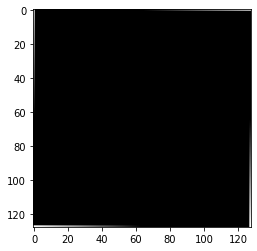

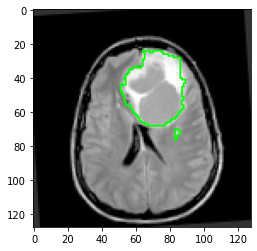

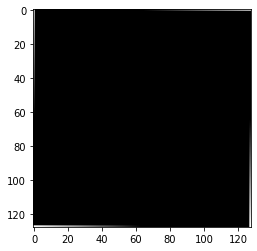

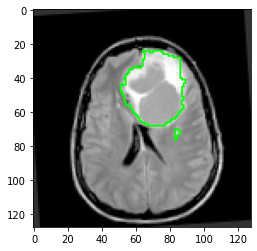

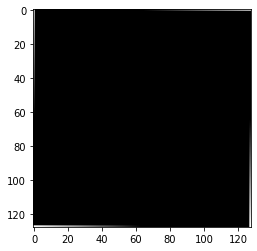

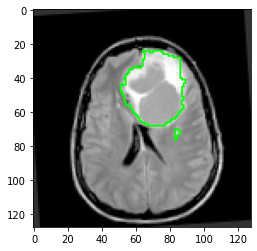

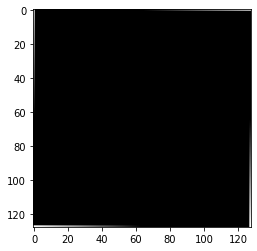

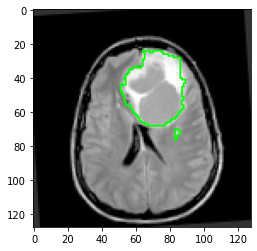

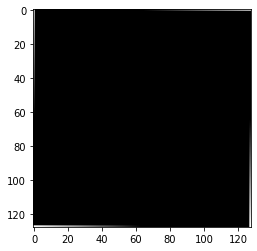

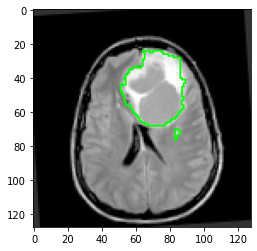

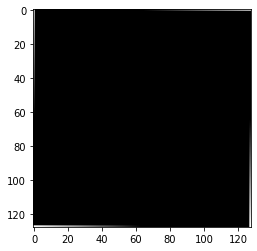

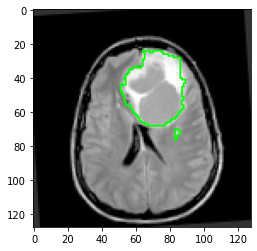

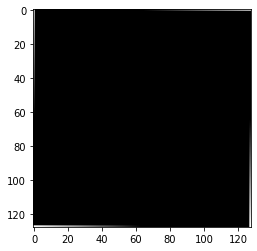

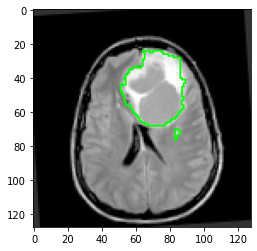

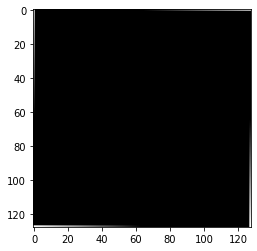

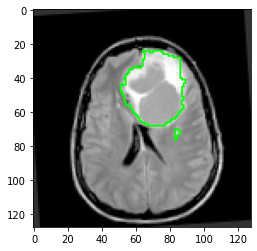

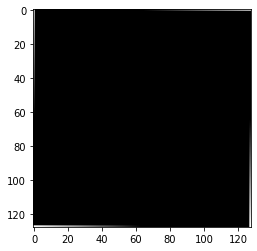

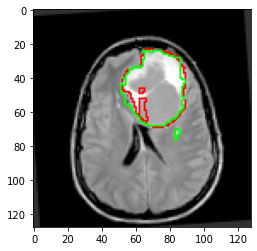

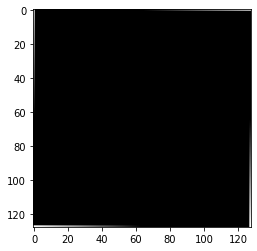

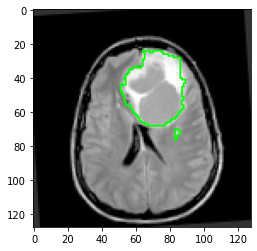

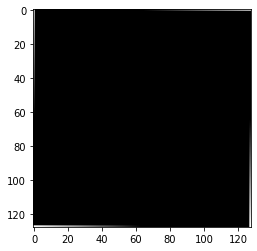

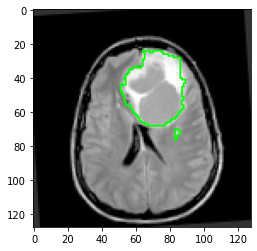

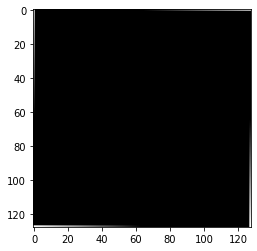

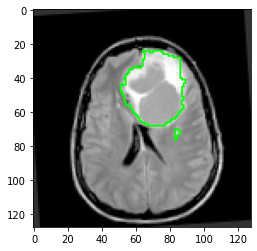

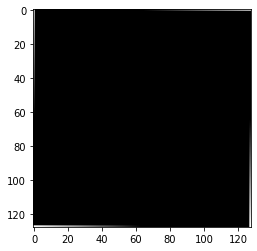

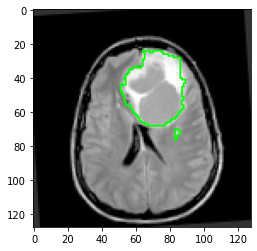

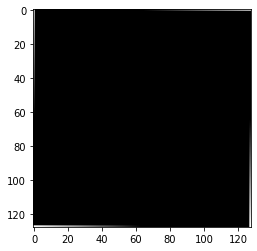

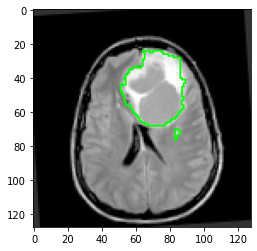

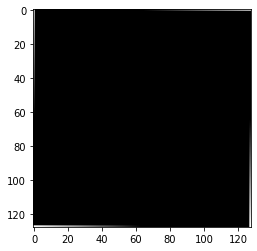

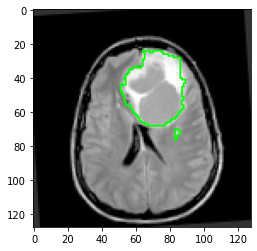

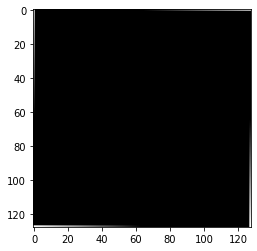

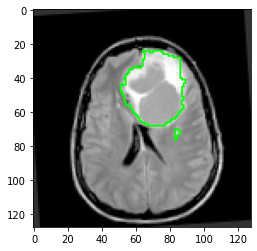

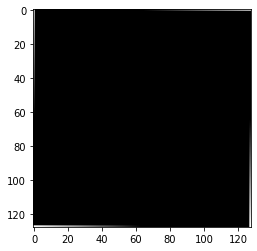

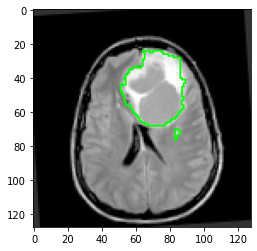

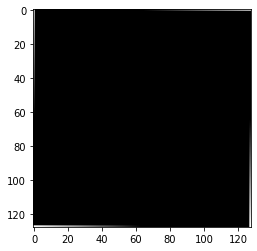

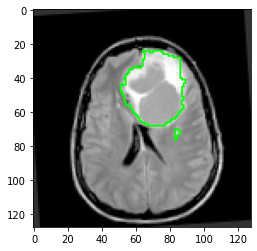

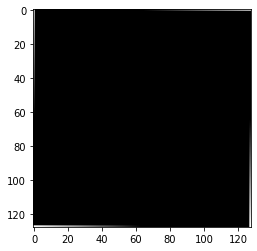

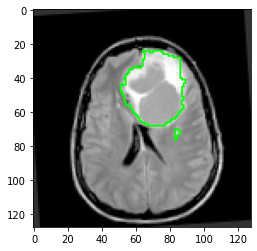

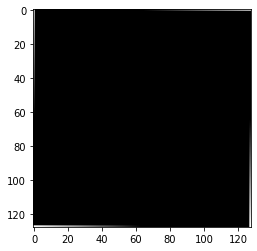

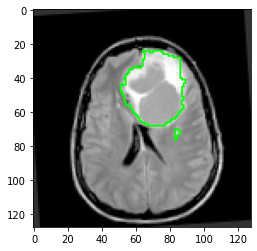

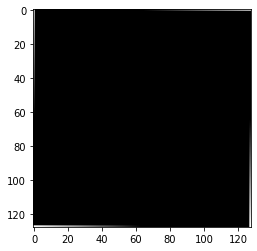

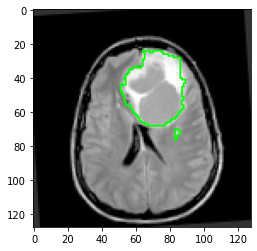

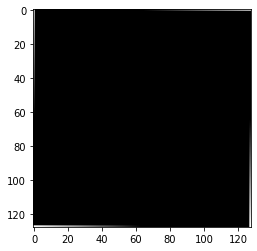

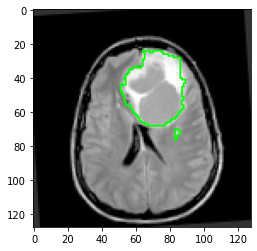

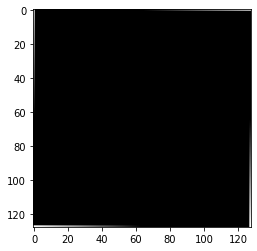

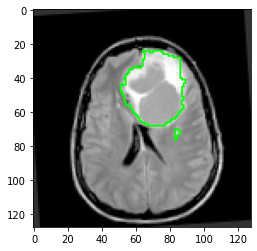

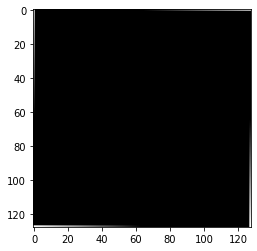

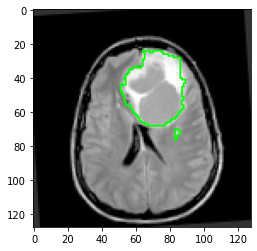

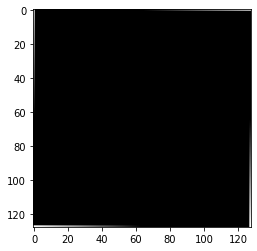

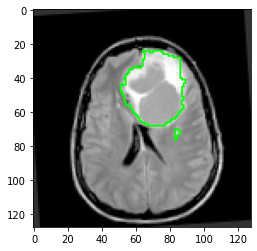

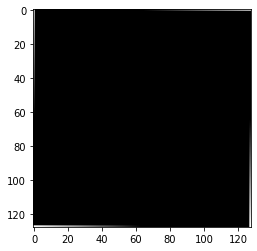

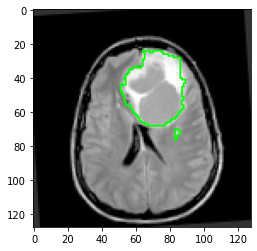

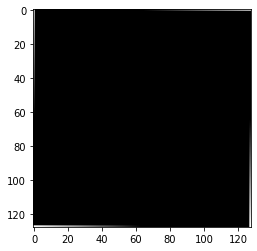

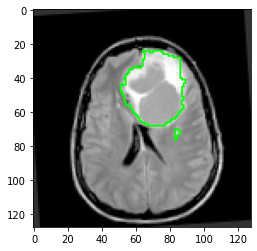

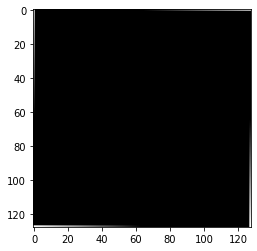

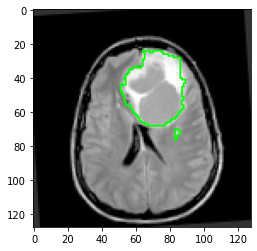

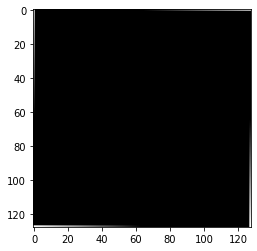

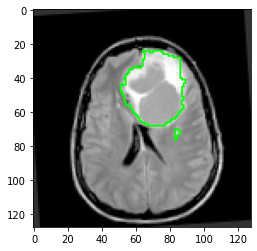

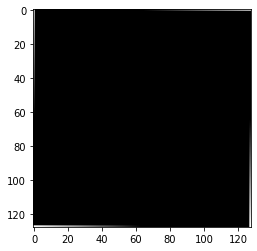

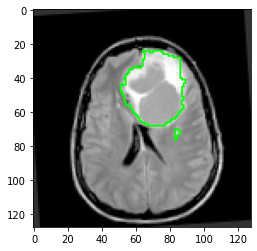

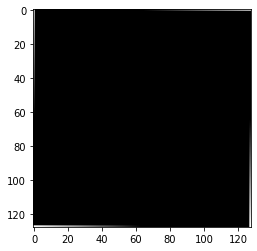

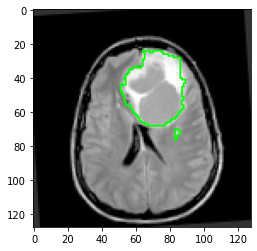

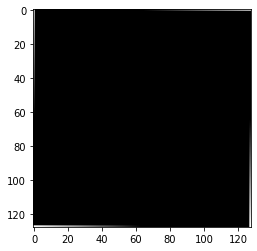

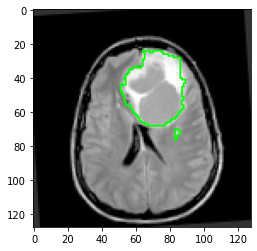

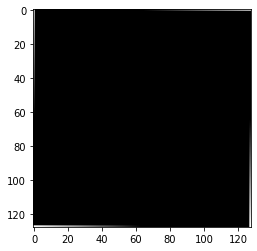

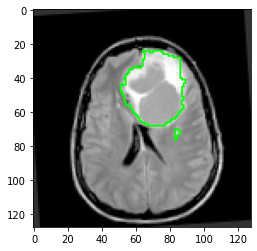

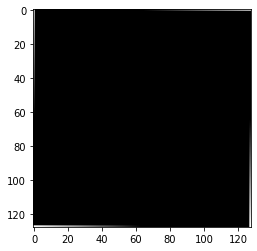

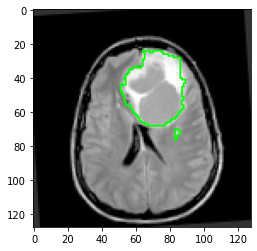

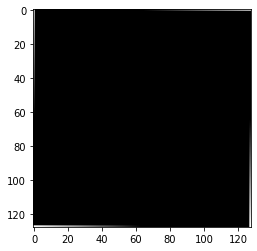

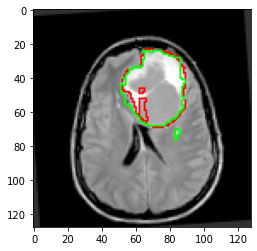

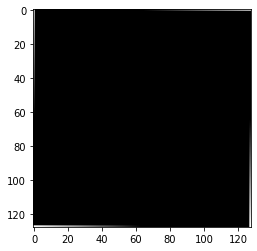

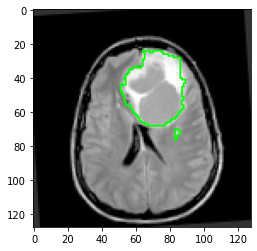

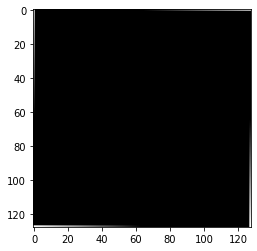

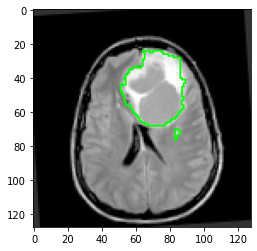

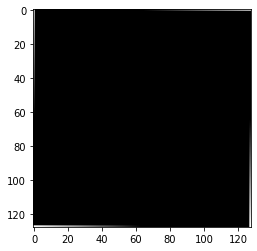

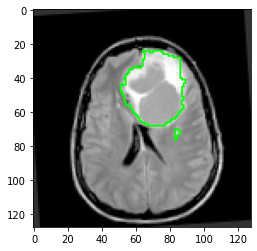

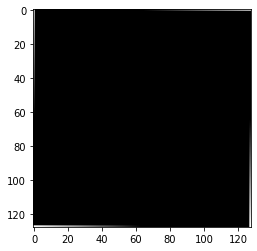

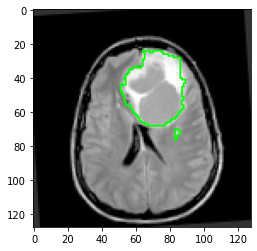

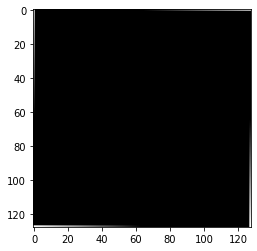

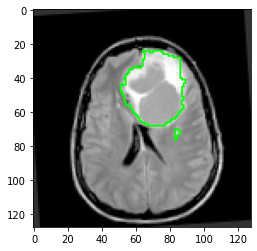

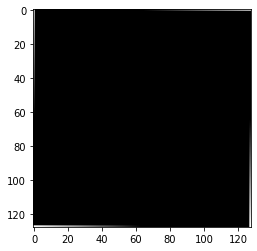

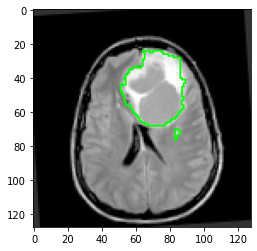

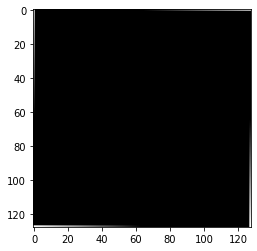

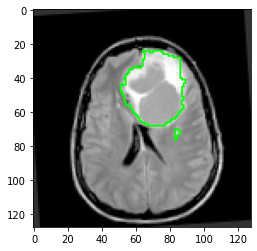

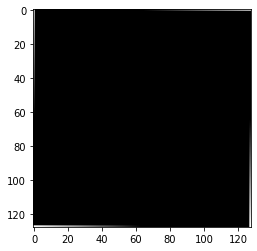

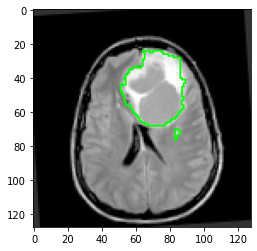

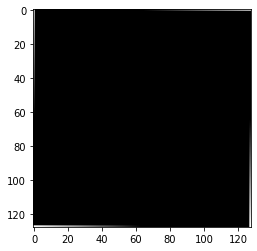

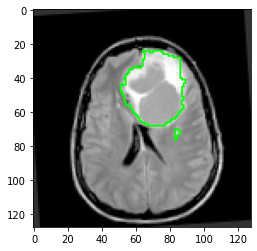

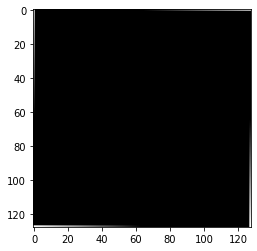

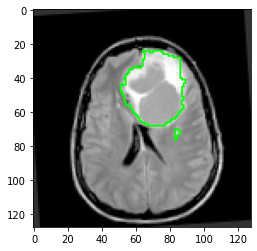

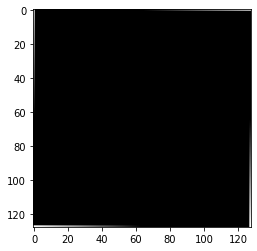

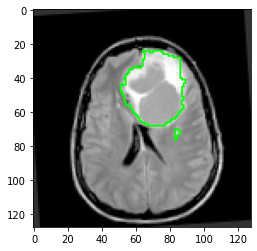

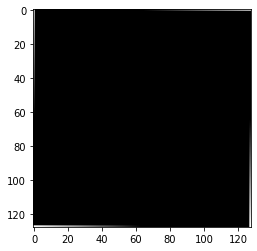

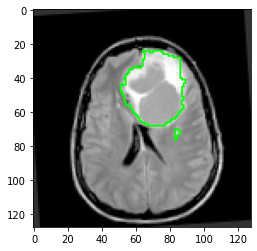

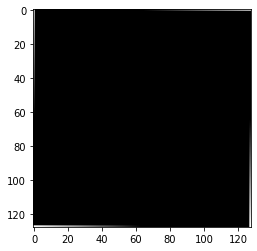

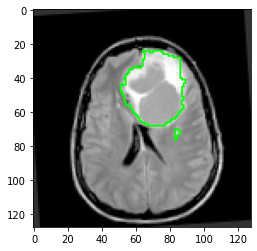

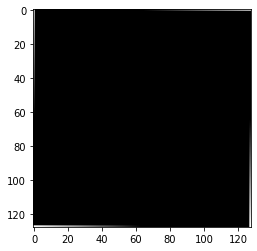

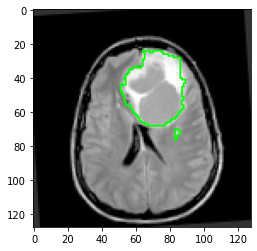

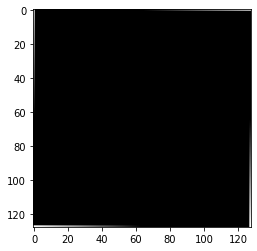

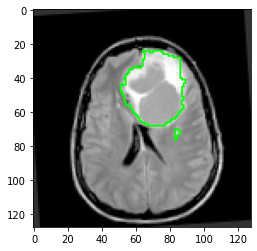

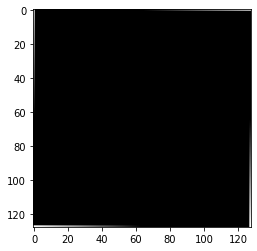

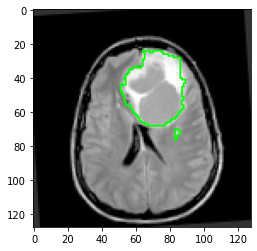

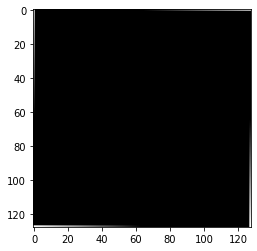

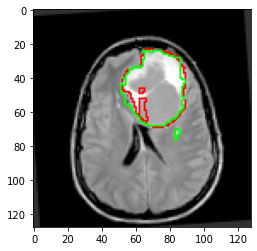

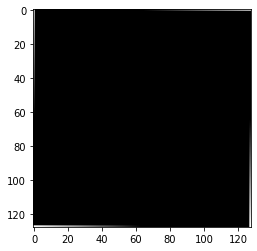

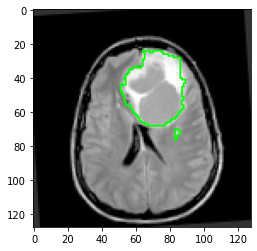

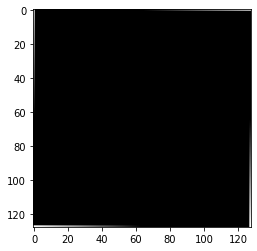

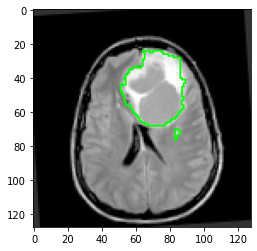

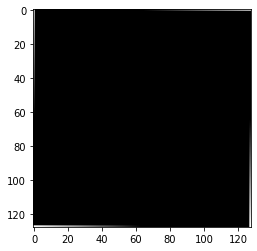

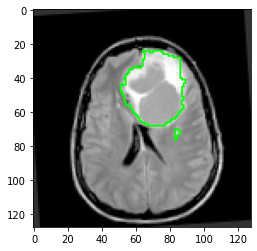

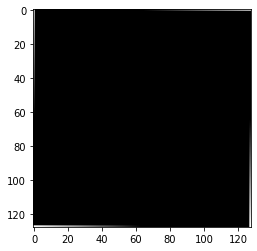

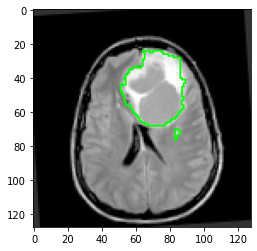

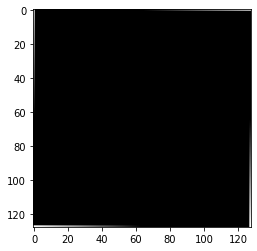

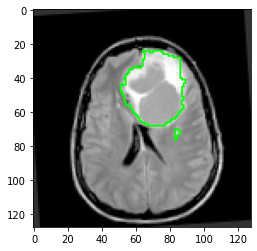

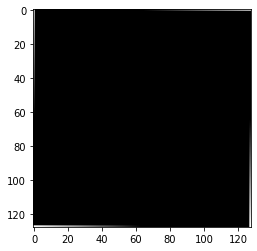

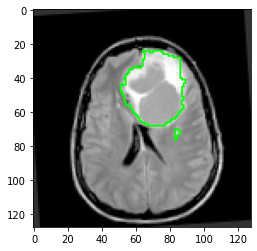

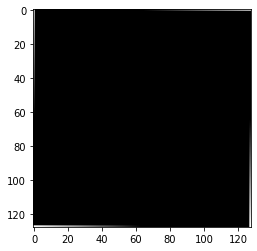

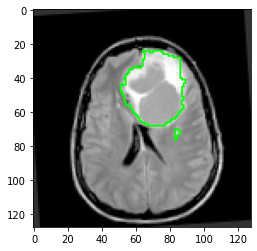

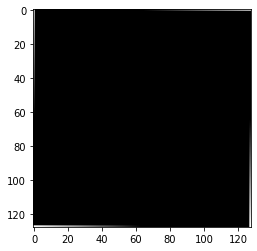

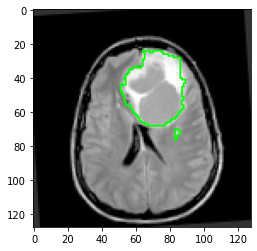

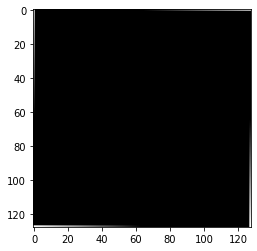

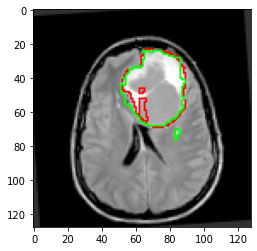

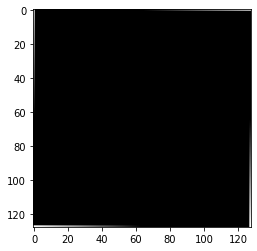

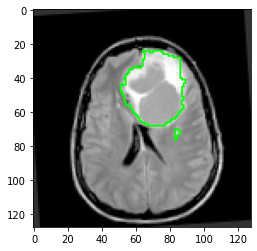

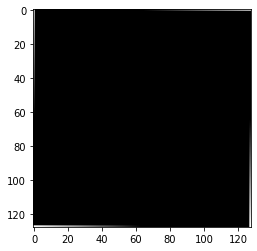

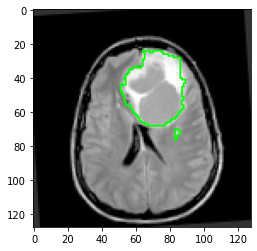

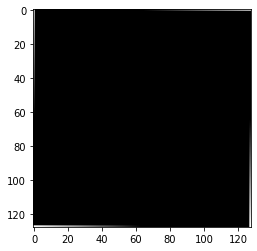

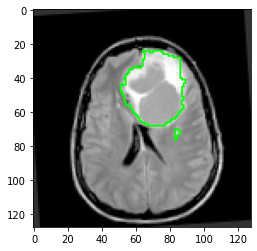

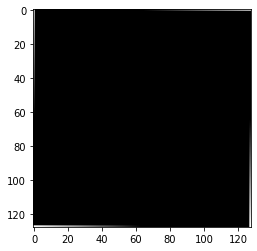

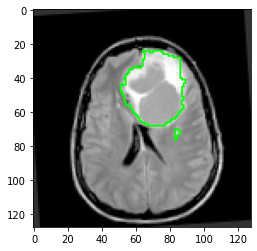

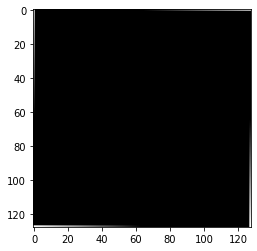

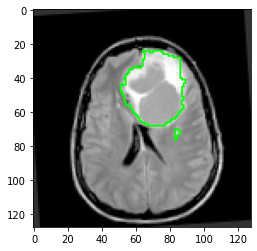

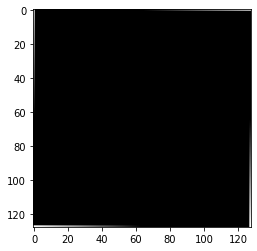

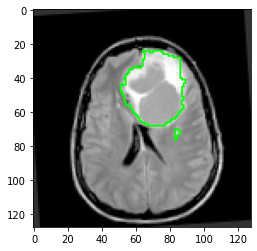

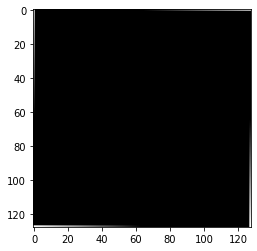

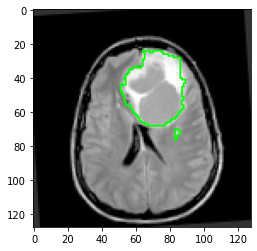

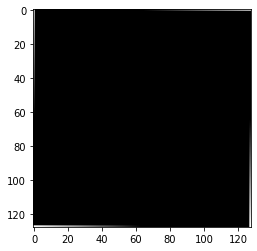

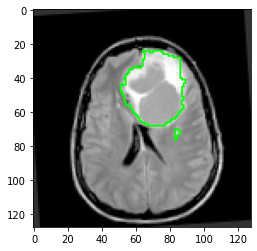

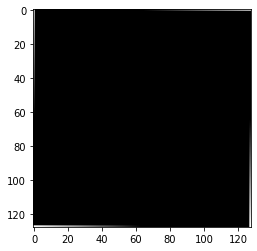

In [69]:
#displaying predictions
for filename in glob.glob('/content/drive/MyDrive/dataset/preds/*'):
  img = plt.imread(filename)
  plt.imshow(img)
  plt.show()
  # green - GT
  # red - pred

# End Remarks
To increase Dice score, Do the following
1. Train on 228*228 with Colab Pro which will give more RAM.
2. Train till loss converges and dice score increases beyond the current 100 epochs.